In [1]:
import os
os.chdir('/home/jknize/main/repo/CSC578/detectron2')
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
register_coco_instances("coco_train_dog", {}, "../datasets/coco/annotations/dog_instances_train2017.json", "../datasets/coco/train2017_dog")
register_coco_instances("coco_val_dog", {}, "../datasets/coco/annotations/dog_instances_val2017.json", "../datasets/coco/val2017_dog")

In [3]:
from detectron2.utils.visualizer import Visualizer
import random
import cv2
import matplotlib.pyplot as plt

my_dataset_metadata = MetadataCatalog.get("coco_train_dog")
my_dataset_metadata.thing_classes = ["dog"]
dataset_dicts = DatasetCatalog.get("coco_train_dog")

from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
import torch

cfg = get_cfg()
cfg.merge_from_file("configs/COCO-Detection/hebb_knize0.yaml")
cfg.OUTPUT_DIR = "knize/output/hebb_sandbox"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 

cfg.DATASETS.TRAIN = ("coco_train_dog",)
cfg.DATASETS.TEST = ("coco_val_dog",)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.OUTPUT_LAYER_SIZE = 1
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 1

# set each image to 224x224 for dev purposes. we will want to change this later to improve performance
cfg.INPUT.MIN_SIZE_TRAIN = (28,)
cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING = "choice"
cfg.INPUT.MAX_SIZE_TRAIN = 28
cfg.INPUT.MIN_SIZE_TEST = 28
cfg.INPUT.MAX_SIZE_TEST = 28
# cfg.PROPOSAL_GENERATOR: PrecomputedProposals # this may be an option to potentially avoid issues with proposal generation
# TODO: think about image normalization "cfg.PIXEL_MEAN"
cfg.MODEL.ROI_HEADS.IN_FEATURES: ['res4']

cfg.MODEL.ROI_HEADS.NAME = "StandardROIHeads"
cfg.MODEL.ROI_BOX_HEAD.NAME = "FastRCNNConvFCHead"
cfg.MODEL.ROI_BOX_HEAD.FC_DIM = 16
cfg.MODEL.ROI_BOX_HEAD.CONV_DIM = 8
# TODO i'm not sure how to set these two up below (pave)
cfg.MODEL.ROI_BOX_HEAD.NUM_CONV = 2
cfg.MODEL.ROI_BOX_HEAD.NUM_FC = 2

# run on GPU
cfg.MODEL.DEVICE = 'cuda'

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# # evaluate performance of trained subset model
# cfg.MODEL.WEIGHTS = "./knize/output/dog_ROI_HEAD_tinkering/model_final.pth"

# trainer.model.eval()
# trainer = DefaultTrainer(cfg)

# evaluator = COCOEvaluator("coco_val_dog", ("bbox",), False, output_dir="./knize/output/hebb_sandbox")
val_loader = build_detection_test_loader(cfg, "coco_val_dog")
# print(inference_on_dataset(trainer.model, val_loader, evaluator))

## I don't know why the score doesn't evaluate correctly when loading the model

[11/17 12:53:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): HebbNet(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (hebbian_weights): Linear(in_features=12288, out_features=16384, bias=False)
    (classification_weights): Linear(in_features=16384, out_features=1, bias=True)
    (relu): ReLU()
    (softmax): LogSoftmax(dim=1)
  )
  (roi_heads): StandardROIHeads(
    (box_pooler): ROIPooler(
      (level_poolers): ModuleList(
        (0): ROIAlign(output_size=(14, 14), spatial_scale=1.0, sampling_ratio=0, aligned=True)
      )
    )
    (box_head): FastRCNNConvFCHead(
      (conv1): Conv2d(
        4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
        (activation): ReLU()
      )
      (conv2): Conv2d(
        8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
        (activation): ReLU()
      )
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (fc1): Linear(in_features=1568, out_features=32, bias=True)
      (fc_relu1): ReLU()
      (fc2): Line

In [5]:
predictor = DefaultPredictor(cfg)

dataset_dicts = DatasetCatalog.get("coco_val_dog")

[11/17 12:54:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./knize/output/dog_ROI_HEAD_tinkering/model_final.pth ...


RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [18]:
for d in dataset_dicts[:]:
    img = cv2.imread(d["file_name"])
    
    # Get model predictions
    try:
        outputs = predictor(img)
        # Visualize the predictions
        v = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("coco_val_dog"), scale=0.5)
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
        # Plot the image
        plt.figure(figsize=(10, 10))
        plt.imshow(out.get_image())
        plt.axis("off")
        plt.show()
    except:
        "No proposal"

In [4]:
# from detectron2.data import build_detection_test_loader
# val_loader = build_detection_test_loader(cfg, "coco_val_dog")

cfg.MODEL.IMG_VIS = True
cfg.MODEL.FEAT_VIS = True
cfg.MODEL.FEAT_VIS_NUM = 1

trainer = DefaultTrainer(cfg)
trainer.model.to(cfg.MODEL.DEVICE)

[11/18 16:05:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): HebbNet(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (hebbian_weights): Linear(in_features=2352, out_features=12544, bias=False)
    (classification_weights): Linear(in_features=12544, out_features=1, bias=True)
    (relu): ReLU()
    (softmax): LogSoftmax(dim=1)
  )
  (roi_heads): StandardROIHeads(
    (box_pooler): ROIPooler(
      (level_poolers): ModuleList(
        (0): ROIAlign(output_size=(14, 14), spatial_scale=1.0, sampling_ratio=0, aligned=True)
      )
    )
    (box_head): FastRCNNConvFCHead(
      (conv1): Conv2d(
        16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
        (activation): ReLU()
      )
      (conv2): Conv2d(
        8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
        (activation): ReLU()
      )
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (fc1): Linear(in_features=1568, out_features=16, bias=True)
      (fc_relu1): ReLU()
      (fc2): Line

GeneralizedRCNN(
  (backbone): HebbNet(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (hebbian_weights): Linear(in_features=2352, out_features=12544, bias=False)
    (classification_weights): Linear(in_features=12544, out_features=1, bias=True)
    (relu): ReLU()
    (softmax): LogSoftmax(dim=1)
  )
  (roi_heads): StandardROIHeads(
    (box_pooler): ROIPooler(
      (level_poolers): ModuleList(
        (0): ROIAlign(output_size=(14, 14), spatial_scale=1.0, sampling_ratio=0, aligned=True)
      )
    )
    (box_head): FastRCNNConvFCHead(
      (conv1): Conv2d(
        16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
        (activation): ReLU()
      )
      (conv2): Conv2d(
        8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
        (activation): ReLU()
      )
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (fc1): Linear(in_features=1568, out_features=16, bias=True)
      (fc_relu1): ReLU()
      (fc2): Linear(in_features=16, out_features=16, bias=Tru

[11/18 16:06:35 d2.engine.train_loop]: Starting training from iteration 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pooled image:


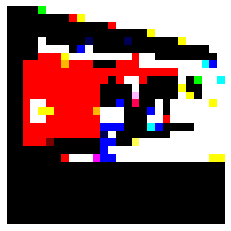

Flattened image:


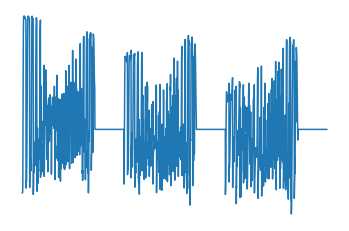

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reshaped image:


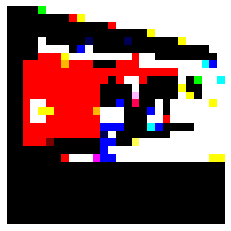

Feature map visualization: 1


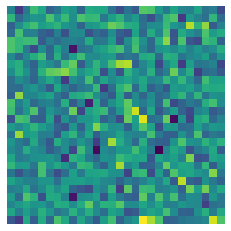

ERROR [11/18 16:06:35 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/home/jknize/main/repo/CSC578/detectron2/detectron2/engine/train_loop.py", line 156, in train
    self.after_step()
  File "/home/jknize/main/repo/CSC578/detectron2/detectron2/engine/train_loop.py", line 190, in after_step
    h.after_step()
  File "/home/jknize/main/repo/CSC578/detectron2/detectron2/engine/hooks.py", line 359, in after_step
    self.scheduler.step()
  File "/home/jknize/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py", line 154, in step
    values = self.get_lr()
  File "/home/jknize/main/repo/CSC578/detectron2/detectron2/solver/lr_scheduler.py", line 124, in get_lr
    multiplier = self._multiplier(self.last_epoch / self._max_iter)
  File "/home/jknize/.local/lib/python3.8/site-packages/fvcore/common/param_scheduler.py", line 423, in __call__
    return scheduler(scheduler_where)
  File "/home/jknize/.local/lib/python3.8/site-packages/fvco

AttributeError: 'EvalHook' object has no attribute '_func'

In [8]:
trainer.train()

In [17]:
tensor = torch.zeros(1, 3, 28, 28)
print(tensor.shape)
tensor = tensor.squeeze(0)
print(tensor.dim() < 5)
print(tensor.shape)
tensor = tensor.permute(1,2,0).numpy
print(tensor)

torch.Size([1, 3, 28, 28])
True
torch.Size([3, 28, 28])
<built-in method numpy of Tensor object at 0x7f83b3e66720>
